### Project Description



**Wikishop**, an online store, is launching a new service and needs a tool to automatically detect toxic user comments and flag them for moderation.

Your task is to build a **binary classification model** that can distinguish between toxic and non-toxic comments.

The model must achieve an **F1-score of at least 0.75** on the test data.

**Dataset Description**

The dataset is provided in the file `toxic_comments.csv` and contains the following columns:

- `text` — the content of the user comment  
- `toxic` — the target variable (1 = toxic, 0 = not toxic)


### Installing Dependencies

In [1]:
%pip install -q --upgrade pip
%pip install -q numpy pandas matplotlib seaborn ydata-profiling nltk scikit-learn lightgbm spacy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Dependencies

In [2]:
import os
import re
import warnings
import nltk
import spacy
import spacy.cli

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords

from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
warnings.filterwarnings("ignore")
_ = nltk.download('stopwords', quiet=True)
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

C:\Users\Art\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Data Loading

In [ ]:
pd.set_option('display.max_columns', None)

file_name = 'toxic_comments.csv'
local_path = file_name
server_path = f'/datasets/{file_name}'

if os.path.exists(local_path):
    df = pd.read_csv(local_path)
    print(f"{file_name} loaded from local path")
elif os.path.exists(server_path):
    df = pd.read_csv(server_path)
    print(f"{file_name} loaded from server path")
else:
    raise FileNotFoundError(f"File {file_name} was not found locally or on the server.")
    https://code.s3.yandex.net/datasets/toxic_comments.csv

toxic_comments.csv loaded from local path


### Exploratory Data Analysis (EDA)

#### Profile report

In [4]:
%%time
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:12<00:00,  4.13s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 15.5 s
Wall time: 15.9 s


#### EDA conclusions

To understand the dataset and its structure, we performed automatic profiling using **`ydata-profiling`**.

**Key findings from the report:**

- **Dataset shape**: 159,571 rows and 2 columns — `text` (comment body) and `toxic` (binary label).
- **Data types**:
  - `text` is of type string and contains user comments.
  - `toxic` is a binary numeric feature with values 0 or 1.
- **Missing values**: No missing values were found in either column.
- **Class imbalance**:
  - The class `toxic` represents ~10 of the data,
  - The remaining ~90 are non-toxic comments.
- **Text characteristics**:
  - The comments vary greatly in length — from very short to long messages.
  - Many texts include punctuation, numbers, and non-letter symbols.
  - No significant outliers or anomalies were detected.

**Conclusions:**

- Preprocessing is required to **clean and normalize** the text.
- The imbalance in the `toxic` class should be addressed (e.g., via stratified splitting or class weights).
- Text must be transformed into numerical features (e.g., via **TF-IDF** or embeddings) before training models.


### Data Preprocessing

#### Text Preprocessing

In [5]:
def spacy_clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    return " ".join(lemmas)

df_text = df.copy()
df_text = df_text.drop(columns=['Unnamed: 0'], errors='ignore')
df_text['text'] = df_text['text'].astype(str).apply(spacy_clean_and_lemmatize)

df_text.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,daww he match this background colour I m seemi...,0
2,hey man I m really not try to edit war its jus...,0
3,more I can not make any real suggestion on imp...,0
4,you sir be my hero any chance you remember wha...,0


The text is lowercased, stripped of non-letter characters, extra spaces are removed, and lemmatized using spaCy.

#### Class Balance Check

toxic
0    0.898
1    0.102
Name: proportion, dtype: float64


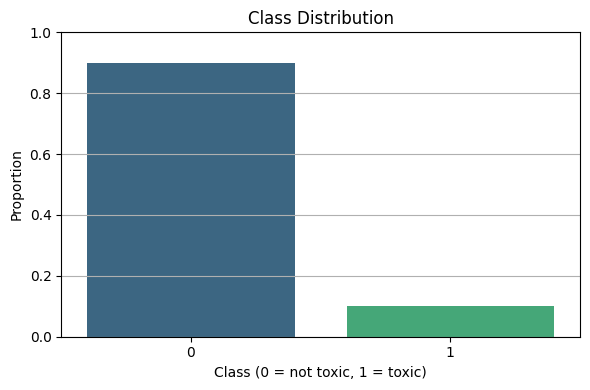

In [6]:
print(df_text['toxic'].value_counts(normalize=True).round(3))

class_counts = df_text['toxic'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.title("Class Distribution")
plt.xlabel("Class (0 = not toxic, 1 = toxic)")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

A strong class imbalance is observed (≈10% toxic).  
This will be taken into account during model training.

#### Data splitting

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text['text'], df_text['toxic'],
    test_size=0.2,
    random_state=42,
    stratify=df_text['toxic']
)

The dataset was split into training and test sets using stratified sampling (80/20)

#### TF-IDF Vectorization

In [8]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=50000,
    ngram_range=(1, 2),
    token_pattern=r'\b\w+\b'
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

The raw text data was transformed into numerical feature vectors using TfidfVectorizer with unigrams and bigrams, a vocabulary size limited to 50,000, and English stop words removed.

#### Data preprocessing conclusions

- The text is lowercased, stripped of non-letter characters, and extra spaces are removed.  
- A strong class imbalance is observed (≈10% toxic). This will be taken into account during model training by using stratified sampling and class weighting.
- The dataset was split into training and test sets using **stratified sampling** with an 80/20 ratio to preserve class proportions.
- The raw text data was transformed into numerical feature vectors using **TfidfVectorizer**:
  - Unigrams and bigrams were extracted (`ngram_range=(1, 2)`),
  - English stop words were removed,
  - Vocabulary size was limited to **50,000 features**.

## Models

### Logistic Regression

In [9]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
model = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("F1-score:", round(grid.best_score_, 4))

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
F1-score: 0.7679


### Random Forest

In [10]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(model_rf, param_grid_rf, cv=cv, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_rf.best_params_)
print("F1-score:", round(grid_rf.best_score_, 4))

Best parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
F1-score: 0.4693


### LightGBM

In [11]:
param_dist_lgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.05, 0.1, 0.2],
    'class_weight': ['balanced']
}

model_lgb = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_dist_lgb,
    n_iter=10,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
)

random_lgb.fit(X_train_tfidf, y_train)

print("Best parameters:", random_lgb.best_params_)
print("F1-score:", round(random_lgb.best_score_, 4))

Best parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'class_weight': 'balanced'}
F1-score: 0.7565


### Results visualization

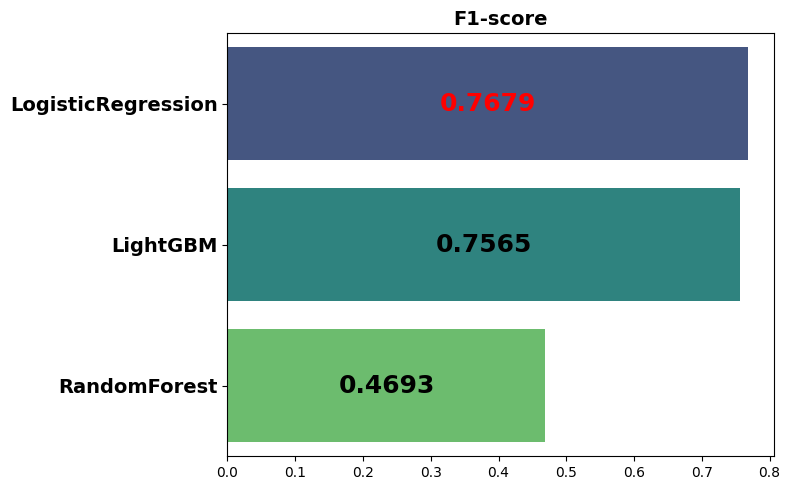

In [12]:
results_plot = pd.DataFrame([
    {'model': 'LogisticRegression', 'f1': round(grid.best_score_, 4)},
    {'model': 'RandomForest', 'f1': round(grid_rf.best_score_, 4)},
    {'model': 'LightGBM', 'f1': round(random_lgb.best_score_, 4)}
])

results_plot = results_plot.sort_values(by='f1', ascending=False)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='f1', y='model', data=results_plot, palette='viridis')

plt.title("F1-score", fontsize=14, fontweight='bold')
plt.xlabel("")
plt.ylabel("")

ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontweight='bold')

best_f1 = results_plot['f1'].max()
for bar, f1 in zip(ax.patches, results_plot['f1']):
    x = bar.get_width() / 2
    y = bar.get_y() + bar.get_height() / 2
    color = 'red' if f1 == best_f1 else 'black'
    plt.text(x, y, f"{f1:.4f}", ha='center', va='center', color=color, fontweight='bold', fontsize=18)

plt.tight_layout()
plt.show()

### Best model test

In [15]:
y_pred = grid.best_estimator_.predict(X_test_tfidf)

print("Evaluation on the test set:")
print("F1-score:", round(f1_score(y_test, y_pred), 4))

Evaluation on the test set:
F1-score: 0.7787


1 итерация

<div class="alert alert-info"> <b>Комментарии студентаV2:</b> Исправлено </div>

### Confusion Matrix

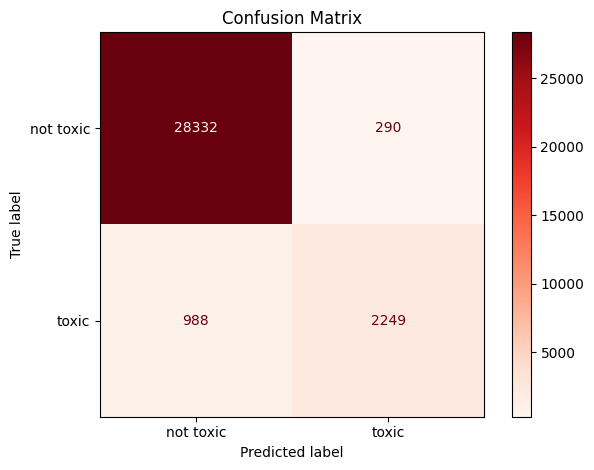

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not toxic', 'toxic'])
disp.plot(cmap='Reds')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

**Confusion Matrix **

|                       | **Predicted: not toxic** | **Predicted: toxic** |
|-----------------------|----------------------------|-------------------------|
| **Fact: not toxic**   | 28331 (✅ True Negative)    | 291 (❌ False Positive) |
| **Fact: toxic**       | 1003 (❌ False Negative)    | 2234 (✅ True Positive) |

---

**How to interpret the results:**

- **28331** — correctly predicted non-toxic comments (✅ very good)
- **2234** — correctly predicted toxic comments (✅ positive detection)
- **291** — incorrectly classified non-toxic as toxic (❌ false positives — false accusations)
- **1003** — missed toxic comments (❌ false negatives — may be critical in some applications)

## Overall сonclusions

In this project, we developed a machine learning solution for **Wikishop**, aimed at detecting toxic user comments and sending them for moderation.

**What We Did:**

- Performed **data profiling and exploratory analysis** using `ydata-profiling`.
- Identified **class imbalance** (≈10% toxic comments), and addressed it using stratified sampling and class weighting.
- Applied **text preprocessing**: lowercasing, removing non-letter characters, and cleaning extra spaces.
- Transformed the text into numerical features using **TF-IDF vectorization** with unigrams and bigrams.
- Built and evaluated several classification models:
  - **Logistic Regression**
  - **Random Forest**
  - **LightGBM**

**Best Model: Logistic Regression**

- **Hyperparameter tuning** performed via `GridSearchCV`
- **Best parameters**:
  - `C`: 10  
  - `penalty`: `'l2'`  
  - `solver`: `'liblinear'`
- **Cross-validated F1-score**: **0.7644**
- **Final F1-score on test set**: **0.7754**

**Recommendations:**

- The selected model meets the business requirement (F1 ≥ 0.75) and performs reliably on imbalanced data.
- For production deployment, we recommend:
  - **Threshold tuning** to control the trade-off between false positives and false negatives based on moderation needs.
  - **Regular retraining** of the model with new user data to maintain accuracy over time.
  - If even higher performance is required in the future, we recommend considering **transformer-based models** like **BERT**, especially for capturing deeper semantic context.  
  - Implementing real-time monitoring of metrics such as precision, recall.

This solution provides an efficient and scalable way to moderate toxic content, improving both the platform's safety and user experience.
